In [1]:
import numpy as np
import os
from skimage.io import imread
from skimage.transform import resize
from DataProcessor import DataProcessor
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Metrics import Metrics
from Model import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

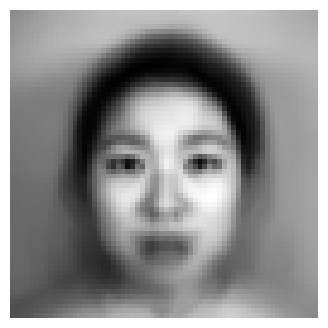

In [2]:
current_directory = os.getcwd()
image_processor = DataProcessor(current_directory)
image_processor.load_images()
image_processor.calculate_mean_image()

In [3]:
image_processor.demean_images()
# image_processor.normalize_images()

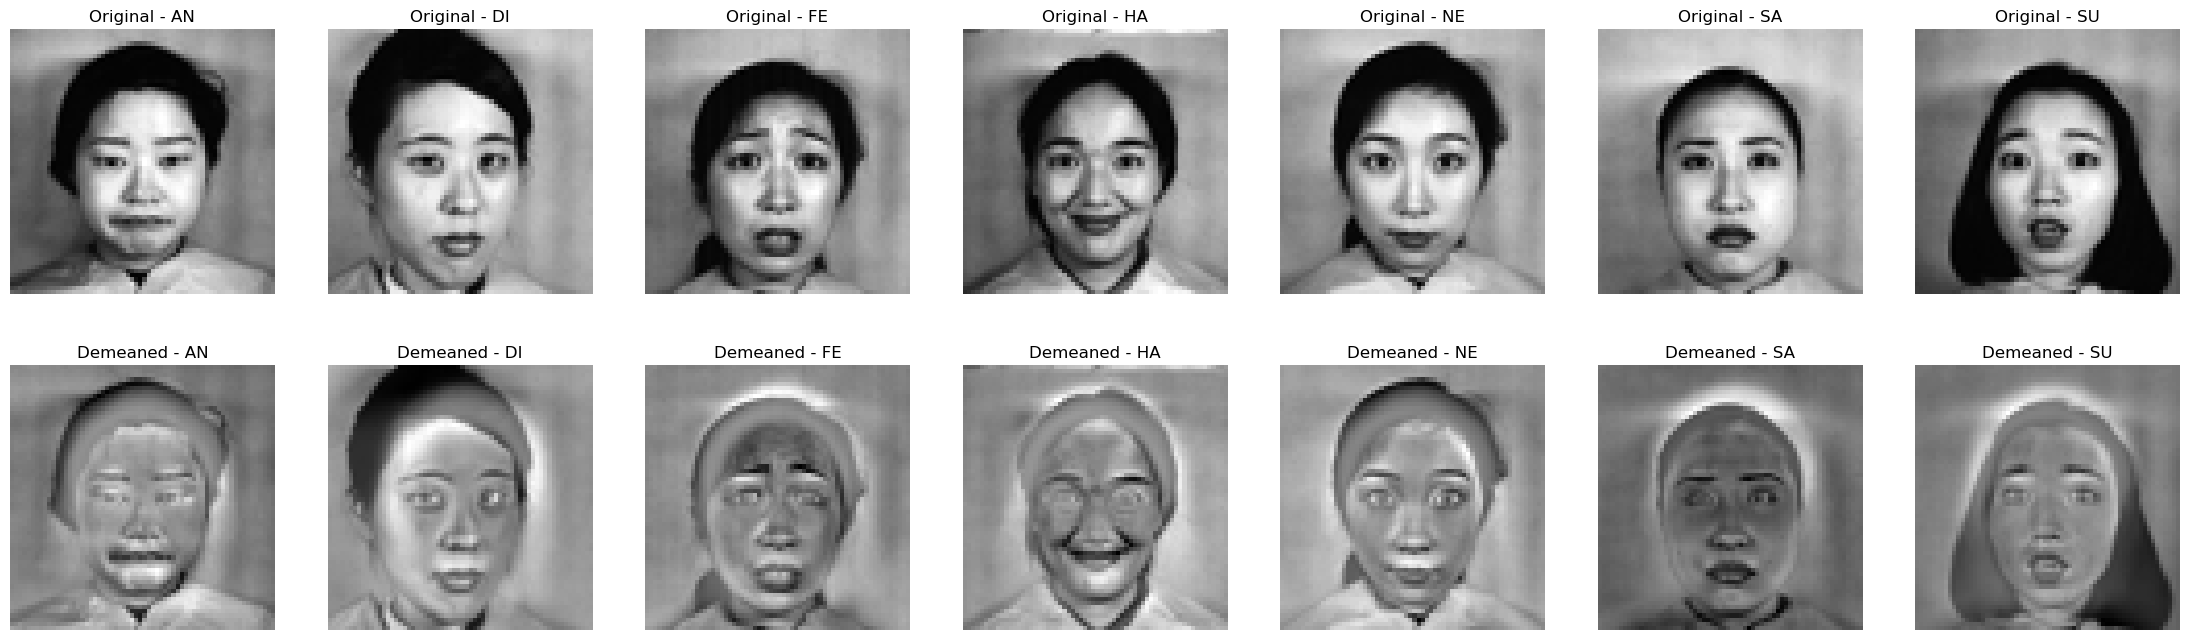

In [4]:
image_processor.visualize_selected_images()

In [5]:
dataset = image_processor.data
images = np.array([list(img) for img in dataset['Image']])

In [6]:
dataset['Image']

0      [0.4276214, 0.45076817, 0.46395308, 0.45970595...
1      [0.44323134, 0.44623986, 0.45970044, 0.4717836...
2      [0.40960607, 0.41909856, 0.41920868, 0.4238670...
3      [0.42821577, 0.4201834, 0.42291802, 0.44041327...
4      [0.45233652, 0.44530162, 0.4554707, 0.47708216...
                             ...                        
165    [0.44166425, 0.45118898, 0.46812564, 0.4638627...
166    [0.45122993, 0.46321568, 0.45574433, 0.4733761...
167    [0.42385137, 0.42840993, 0.44317856, 0.4471746...
168    [0.4045876, 0.42006415, 0.4218337, 0.4367082, ...
169    [0.40222168, 0.41701803, 0.4307734, 0.4375274,...
Name: Image, Length: 170, dtype: object

In [7]:
image_processor.mean_image

array([0.46908831, 0.48073806, 0.49154911, ..., 0.4775873 , 0.46736706,
       0.46302882])

In [8]:

class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.eigenvectors = None
        self.eigenvalues = None
        self.mean = None

    def fit(self, X):
        # Mean centering
        self.mean = np.mean(X, axis=0)
        X = (X - self.mean)
        # Covariance matrix
        cov_matrix = np.cov(X.T)

        # Eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)  # Use eigh for symmetric matrices

        # Sort eigenvectors
        eigenvectors = eigenvectors.T
        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]
        self.eigenvectors = eigenvectors
        self.eigenvalues = eigenvalues
        # Store first n eigenvectors (use real part if complex)
        self.components = np.real(eigenvectors[0:self.n_components])

    def transform(self, X):
        # Project data
        X = (X - self.mean)
        return np.dot(X, self.components.T)
    
    def inverse_transform(self, X):
        # Inverse transform to the original space
        return np.dot(X, self.components) + self.mean


In [9]:
n_components=10
image_size = (64,64)
pca = PCA(n_components)
pca.fit(images)
transformed_images = pca.transform(images)
eigenfaces = pca.components.reshape((n_components, *image_size))

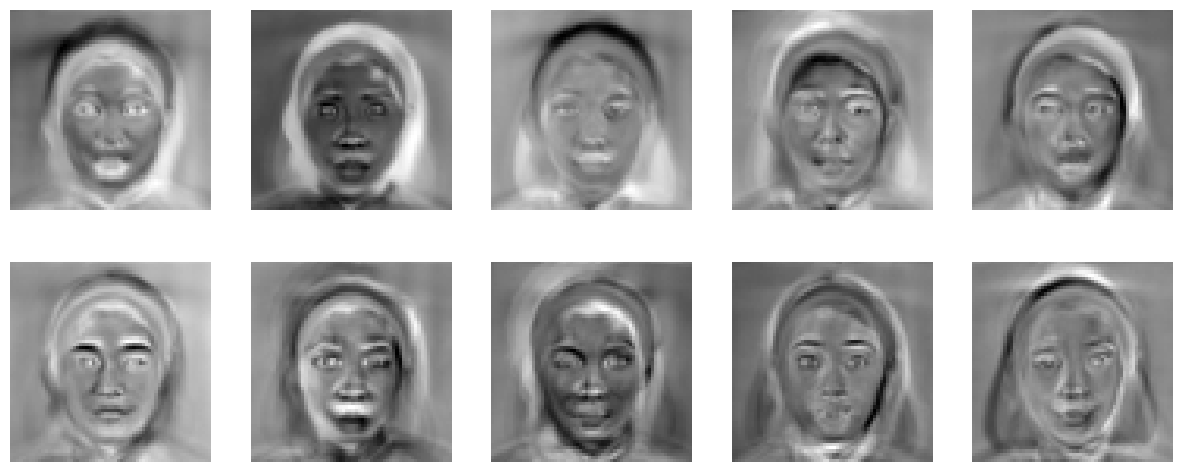

In [10]:
num_eigenfaces = len(eigenfaces)
num_rows = int(np.ceil(num_eigenfaces / 5))
num_columns = min(5, num_eigenfaces)
fig, axes = plt.subplots(num_rows, num_columns, figsize=(3 * num_columns, 3 * num_rows))
for i in range(num_rows):
    for j in range(num_columns):
        index = i * num_columns + j
        if index < num_eigenfaces:
            ax = axes[i, j] if num_rows > 1 else axes[j]
            ax.imshow(eigenfaces[index], cmap='gray')
            ax.axis('off')

plt.show()

inverse transform images: 


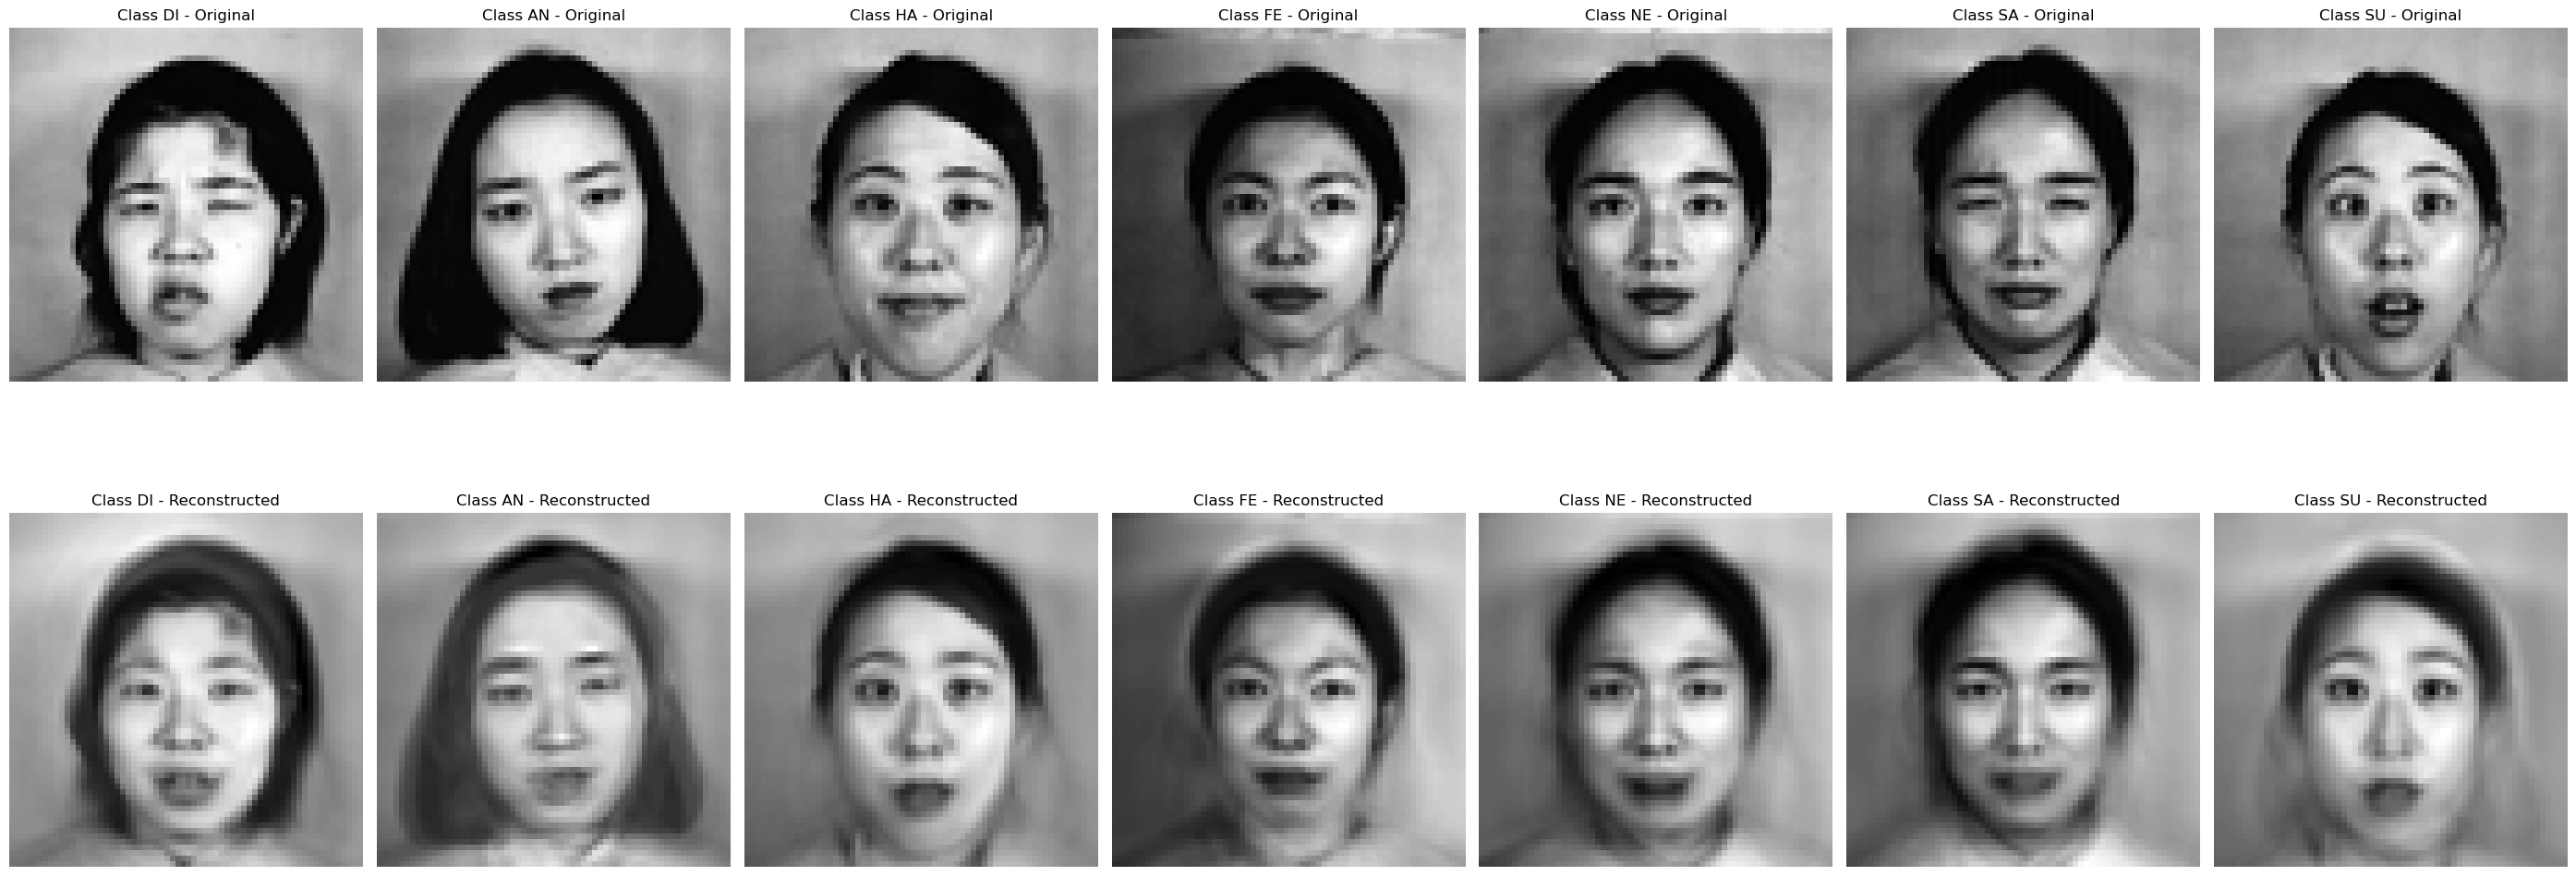

In [11]:
labels = dataset['Expression']
unique_classes = list(set(labels))

print("inverse transform images: ")
reconstructed_images = pca.inverse_transform(transformed_images)
reconstructed_images = reconstructed_images.reshape(-1, *image_size)
fig, axes = plt.subplots(2, len(unique_classes), figsize=(4* len(unique_classes),12))

for i, class_label in enumerate(unique_classes):
    class_indices = np.where(labels == class_label)[0]
    random_index = np.random.choice(class_indices)
    original_image = images[random_index].reshape(image_size)
    reconstructed_image = reconstructed_images[random_index]

    axes[0, i].imshow(original_image, cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Class {class_label} - Original')

    axes[1,i].imshow(reconstructed_image, cmap='gray')
    axes[1,i].axis('off')
    axes[1,i].set_title(f'Class {class_label} - Reconstructed')

plt.tight_layout()
plt.show()

In [12]:
n_components_2d = 2
image_size = (64,64)
pca_2d = PCA(n_components_2d)
pca_2d.fit(images)
transformed_images_2d = pca_2d.transform(images)
eigenfaces_2d = pca_2d.components.reshape((n_components_2d, *image_size))

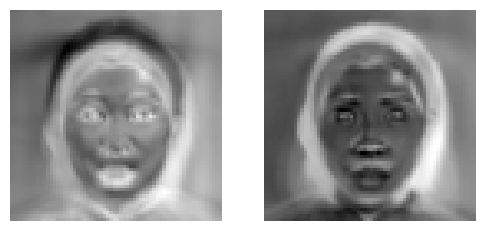

In [13]:
num_eigenfaces_2d = len(eigenfaces_2d)
num_rows = int(np.ceil(num_eigenfaces_2d / 5))
num_columns = min(5, num_eigenfaces_2d)

fig, axes = plt.subplots(num_rows, num_columns, figsize=(3 * num_columns, 3 * num_rows))
for i in range(num_rows):
    for j in range(num_columns):
        index = i * num_columns + j
        if index < num_eigenfaces_2d:
            ax = axes[i, j] if num_rows > 1 else axes[j]
            ax.imshow(eigenfaces_2d[index], cmap='gray')
            ax.axis('off')
plt.show()

inverse transform images: 


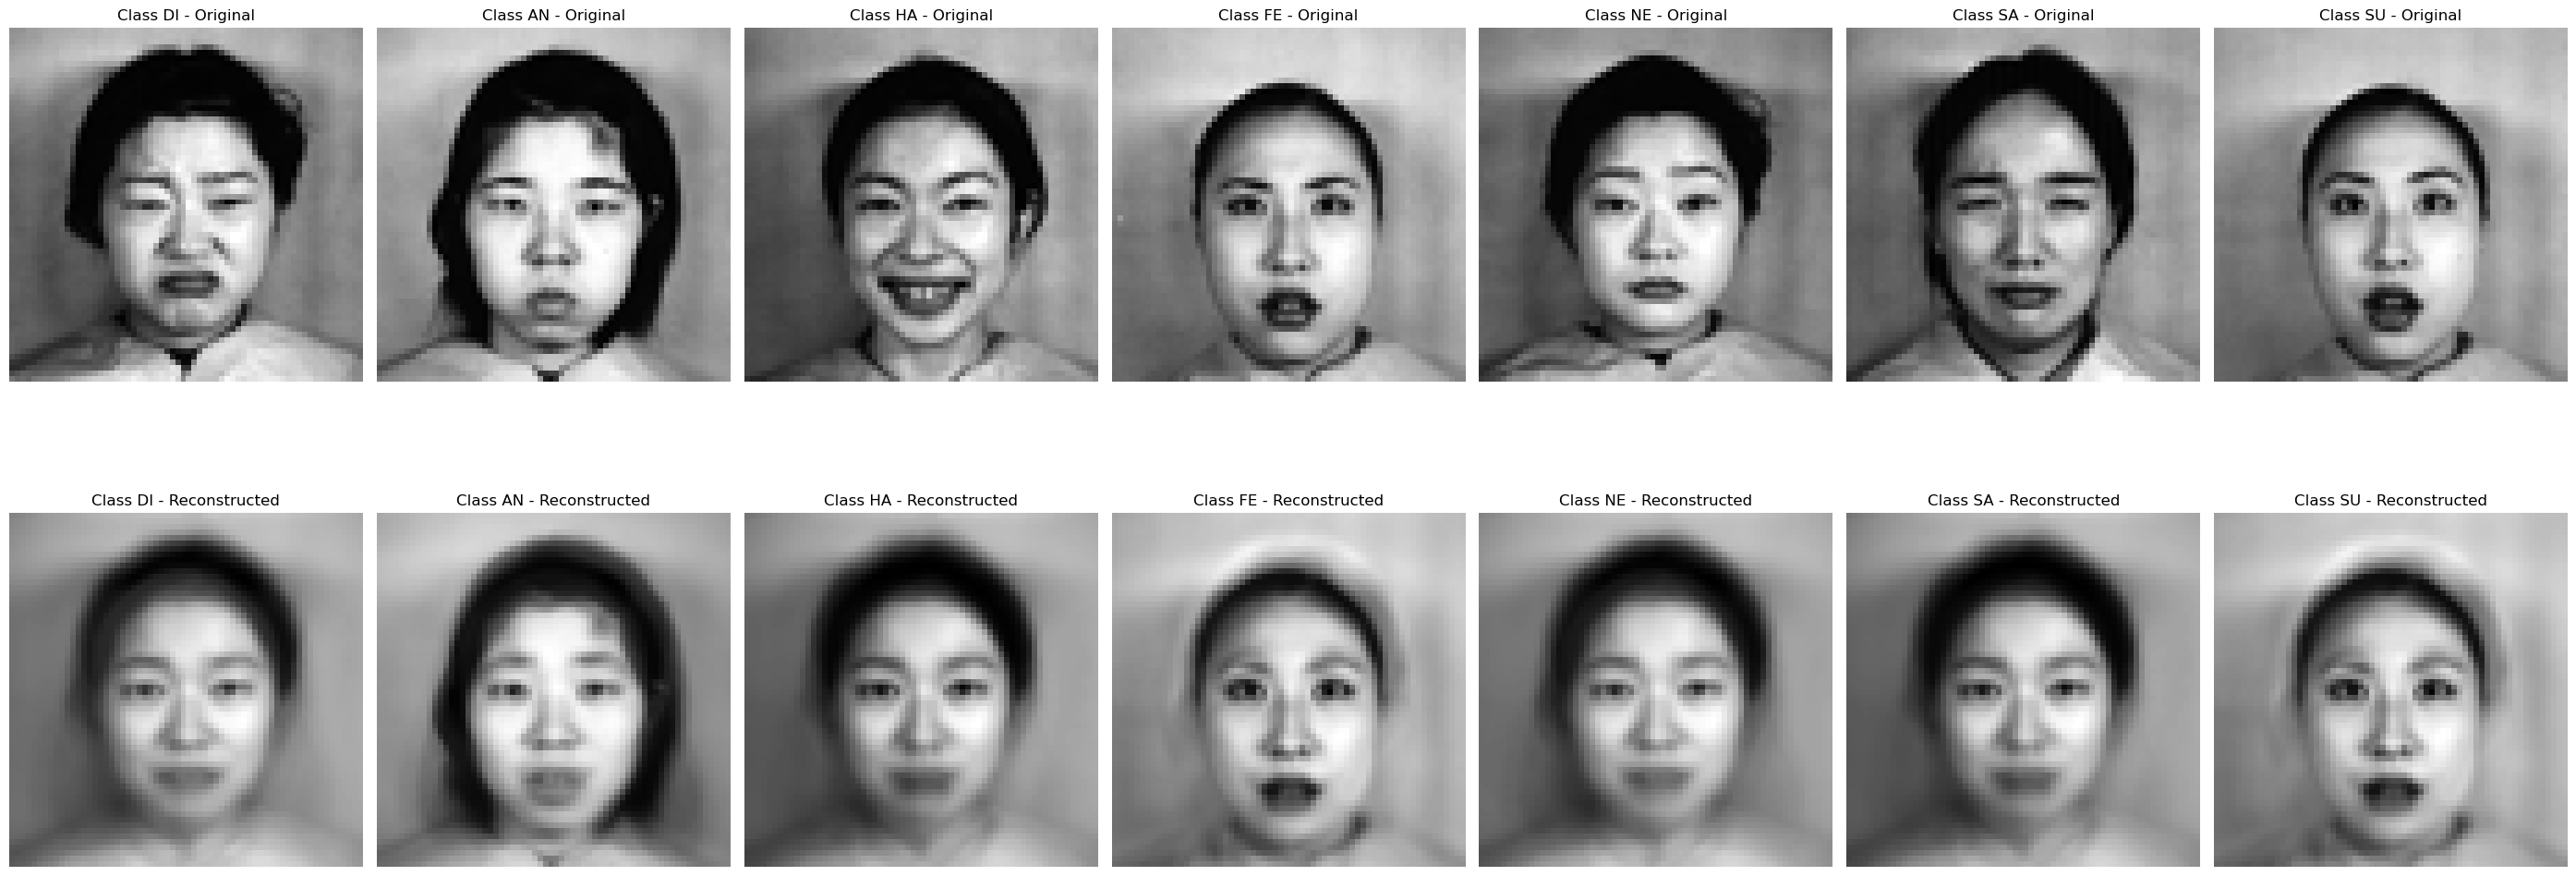

In [14]:
labels = dataset['Expression']
unique_classes = list(set(labels))

print("inverse transform images: ")
reconstructed_images_2d = pca_2d.inverse_transform(transformed_images_2d)
reconstructed_images_2d = reconstructed_images_2d.reshape(-1, *image_size)
fig, axes = plt.subplots(2, len(unique_classes), figsize=(4* len(unique_classes),12))

for i, class_label in enumerate(unique_classes):
    class_indices = np.where(labels == class_label)[0]
    random_index = np.random.choice(class_indices)
    original_image = images[random_index].reshape(image_size)
    reconstructed_image = reconstructed_images_2d[random_index]

    axes[0, i].imshow(original_image, cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Class {class_label} - Original')

    axes[1,i].imshow(reconstructed_image, cmap='gray')
    axes[1,i].axis('off')
    axes[1,i].set_title(f'Class {class_label} - Reconstructed')

plt.tight_layout()
plt.show()

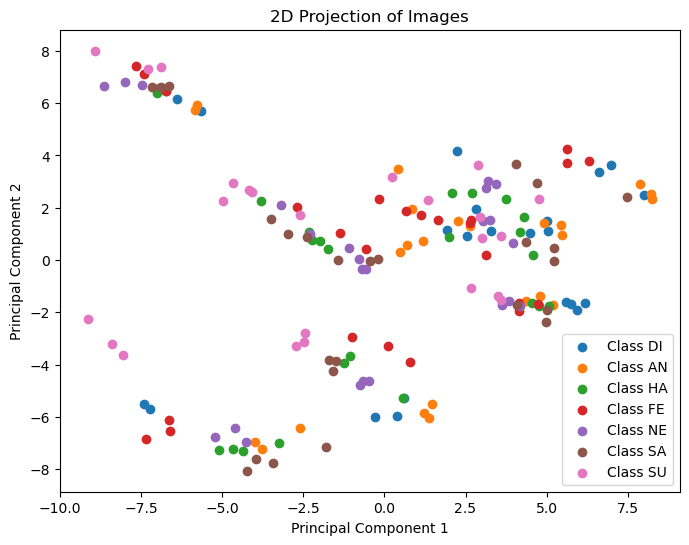

In [15]:
fig = plt.figure(figsize=(8, 6))
for class_label in unique_classes:
    class_indices = np.where(labels == class_label)[0]
    plt.scatter(transformed_images_2d[class_indices, 0], transformed_images_2d[class_indices, 1], label=f'Class {class_label}')

plt.title('2D Projection of Images')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [16]:
n_components_3d = 3
image_size = (64,64)
pca_3d = PCA(n_components_3d)
pca_3d.fit(images)
transformed_images_3d = pca_3d.transform(images)
eigenfaces_3d = pca_3d.components.reshape((n_components_3d, *image_size))

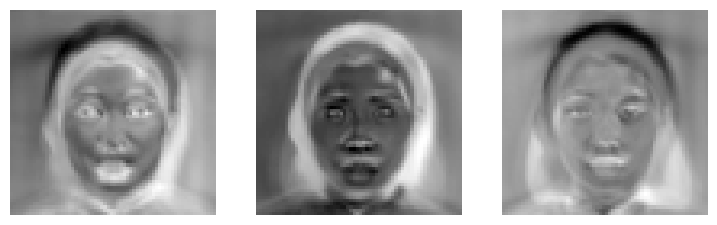

In [17]:
num_eigenfaces_3d = len(eigenfaces_3d)
num_rows = int(np.ceil(num_eigenfaces_3d / 5))
num_columns = min(5, num_eigenfaces_3d)

fig, axes = plt.subplots(num_rows, num_columns, figsize=(3 * num_columns, 3 * num_rows))
for i in range(num_rows):
    for j in range(num_columns):
        index = i * num_columns + j
        if index < num_eigenfaces_3d:
            ax = axes[i, j] if num_rows > 1 else axes[j]  # Adjust based on the number of rows
            ax.imshow(eigenfaces_3d[index], cmap='gray')
            ax.axis('off')

plt.show()

inverse transform images: 


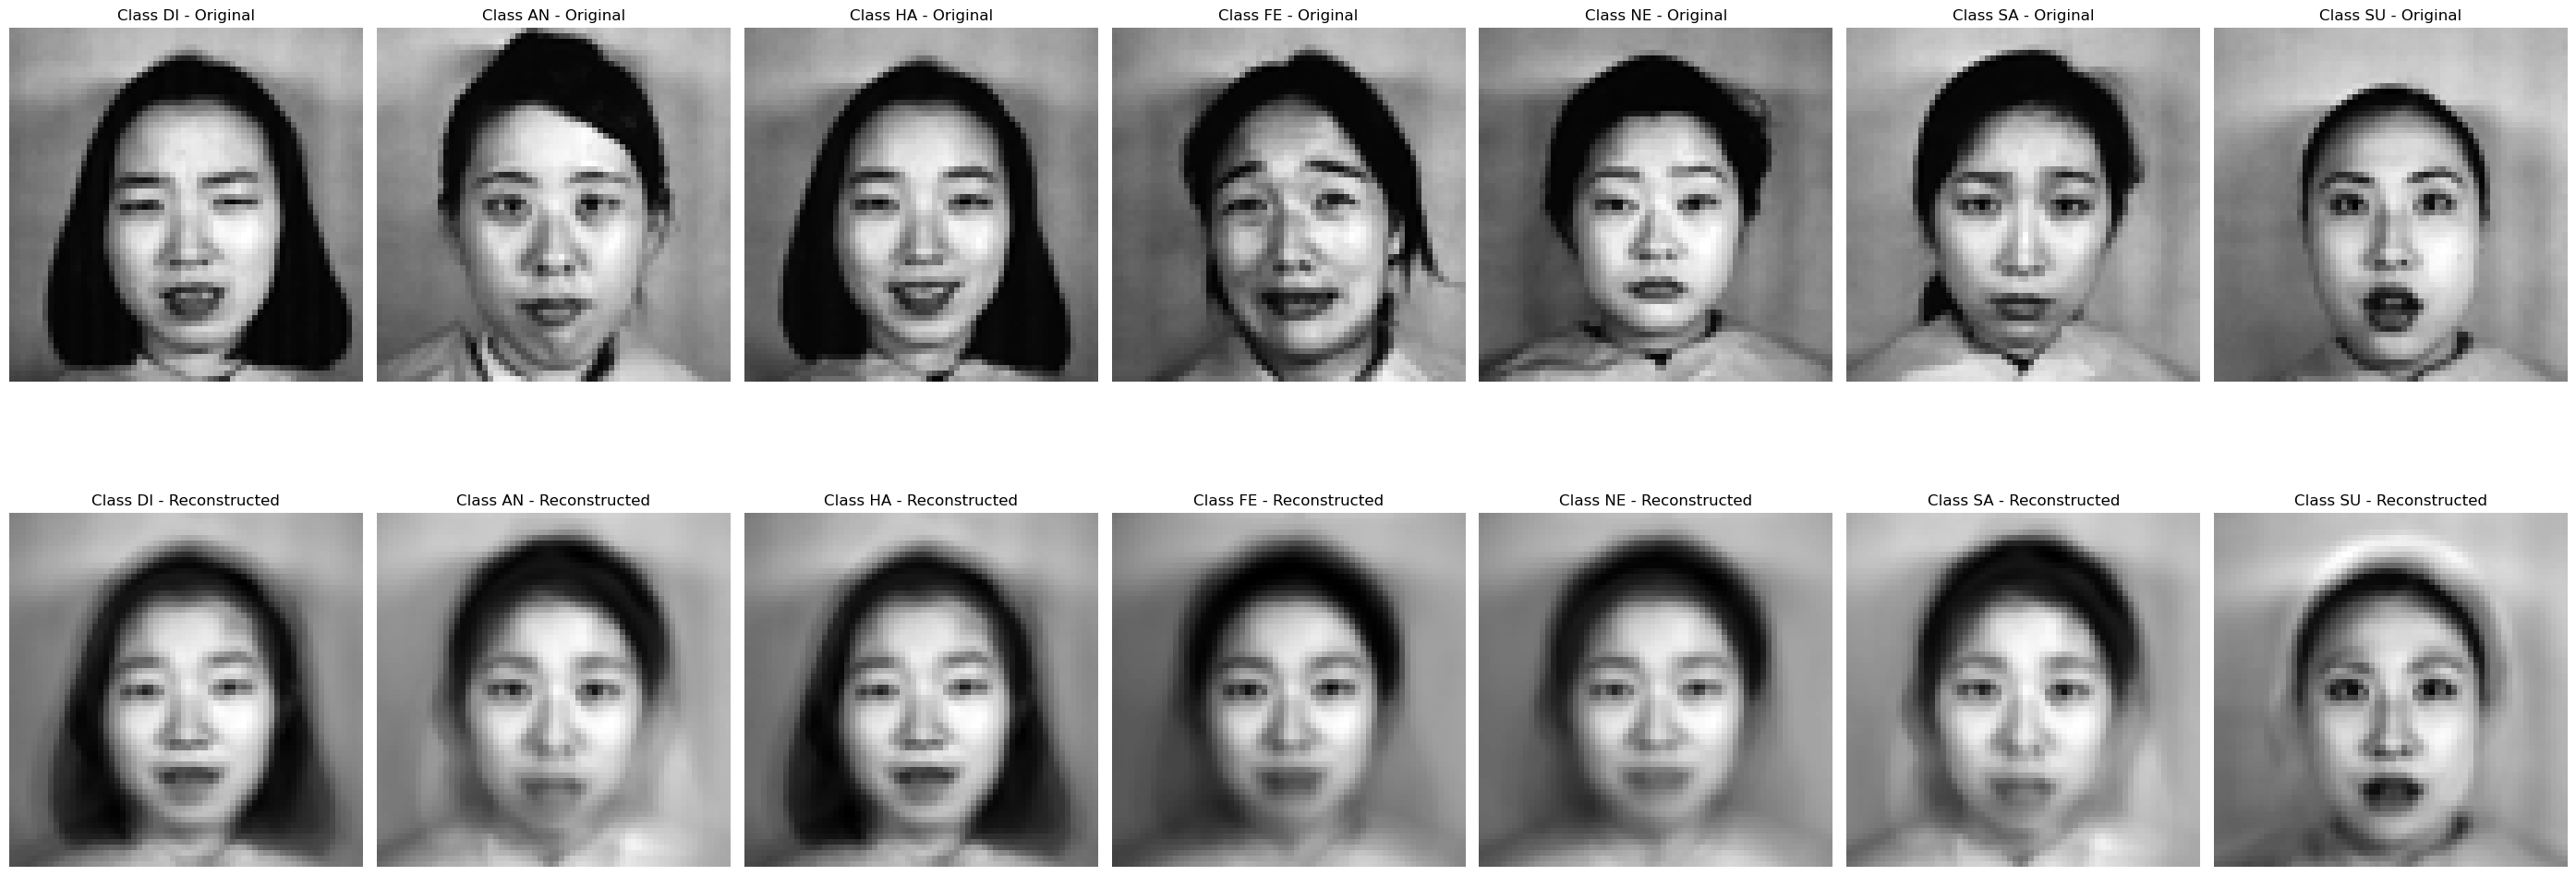

In [18]:
labels = dataset['Expression']
unique_classes = list(set(labels))

print("inverse transform images: ")
reconstructed_images_3d = pca_3d.inverse_transform(transformed_images_3d)
reconstructed_images_3d = reconstructed_images_3d.reshape(-1, *image_size)
fig, axes = plt.subplots(2, len(unique_classes), figsize=(4* len(unique_classes),12))

for i, class_label in enumerate(unique_classes):
    class_indices = np.where(labels == class_label)[0]
    random_index = np.random.choice(class_indices)
    original_image = images[random_index].reshape(image_size)
    reconstructed_image = reconstructed_images_3d[random_index]

    axes[0, i].imshow(original_image, cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Class {class_label} - Original')

    axes[1,i].imshow(reconstructed_image, cmap='gray')
    axes[1,i].axis('off')
    axes[1,i].set_title(f'Class {class_label} - Reconstructed')

plt.tight_layout()
plt.show()

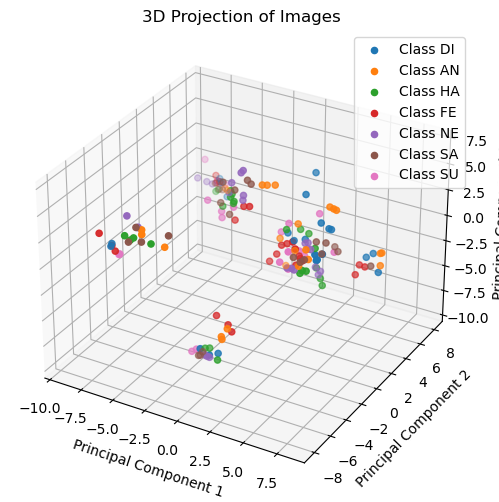

In [19]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for class_label in unique_classes:
    class_indices = np.where(labels == class_label)[0]
    ax.scatter(transformed_images_3d[class_indices, 0], transformed_images_3d[class_indices, 1],
               transformed_images_3d[class_indices, 2], label=f'Class {class_label}')

ax.set_title('3D Projection of Images')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.show()

In [20]:
cumulative_variance = np.cumsum(pca.eigenvalues) / np.sum(pca.eigenvalues)
n_components_90_percent = np.argmax(cumulative_variance >= 0.9) + 1
print(f"Number of components needed for 90% cumulative variance: {n_components_90_percent}")

Number of components needed for 90% cumulative variance: 23


In [21]:
pca_90_percent = PCA(n_components_90_percent)
pca_90_percent.fit(images)
transformed_images_90_percent = pca_90_percent.transform(images)

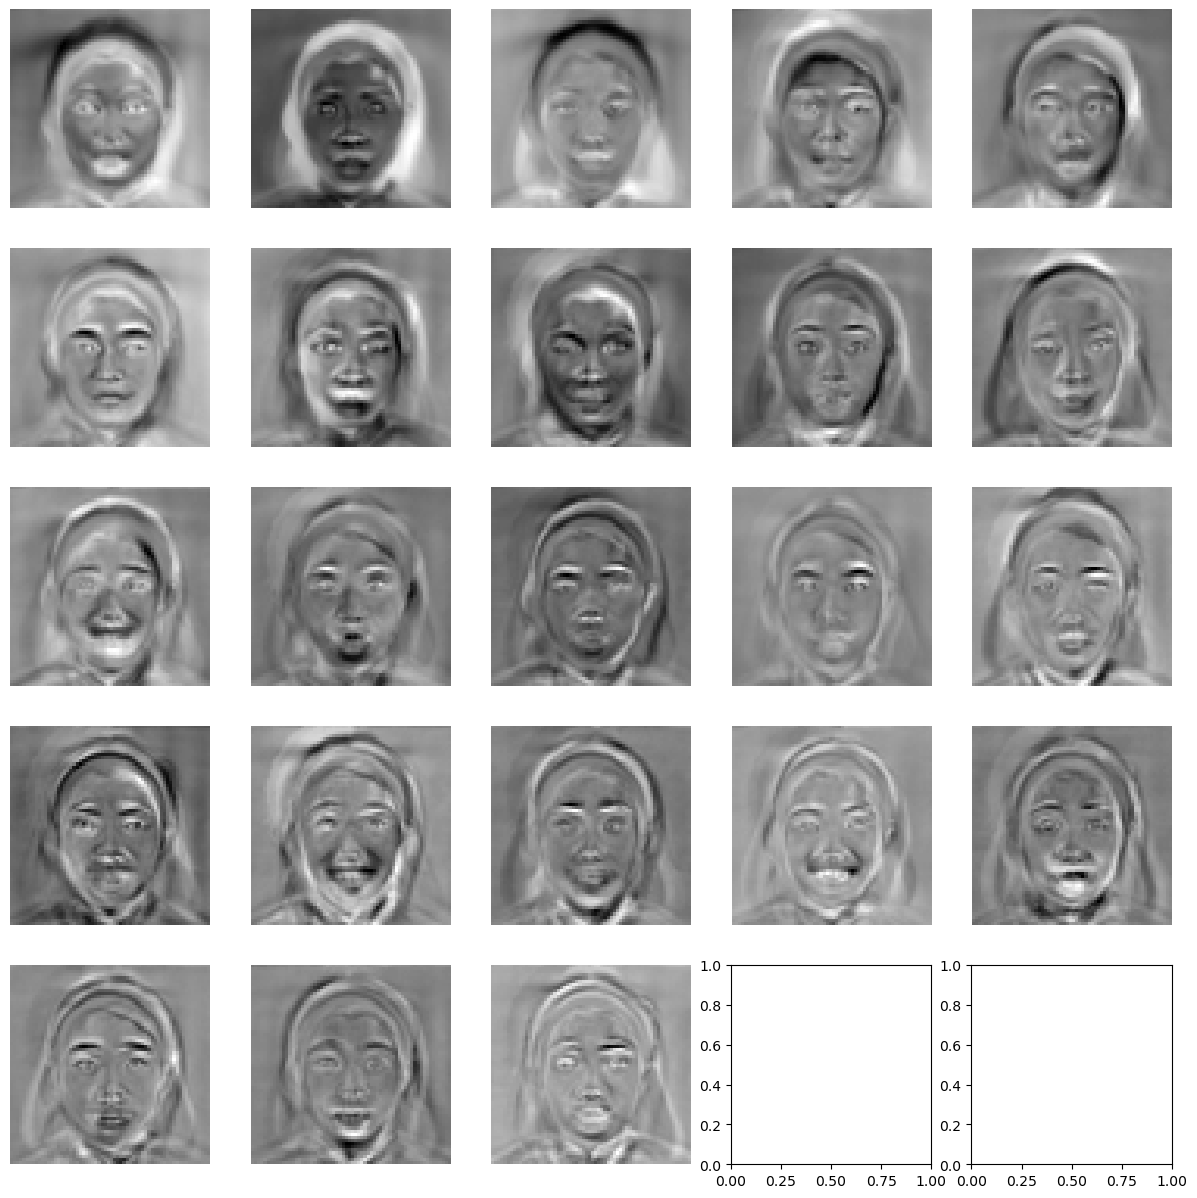

In [22]:
eigenfaces_90_percent = pca_90_percent.components.reshape((n_components_90_percent, *image_size))
num_eigenfaces_90_percent = len(eigenfaces_90_percent)
num_rows = int(np.ceil(num_eigenfaces_90_percent / 5))
num_columns = min(5, num_eigenfaces_90_percent)
fig, axes = plt.subplots(num_rows, num_columns, figsize=(3 * num_columns, 3 * num_rows))
for i in range(num_rows):
    for j in range(num_columns):
        index = i * num_columns + j
        if index < num_eigenfaces_90_percent:
            ax = axes[i, j] if num_rows > 1 else axes[j]
            ax.imshow(eigenfaces_90_percent[index], cmap='gray')
            ax.axis('off')

plt.show()

inverse transform images: 


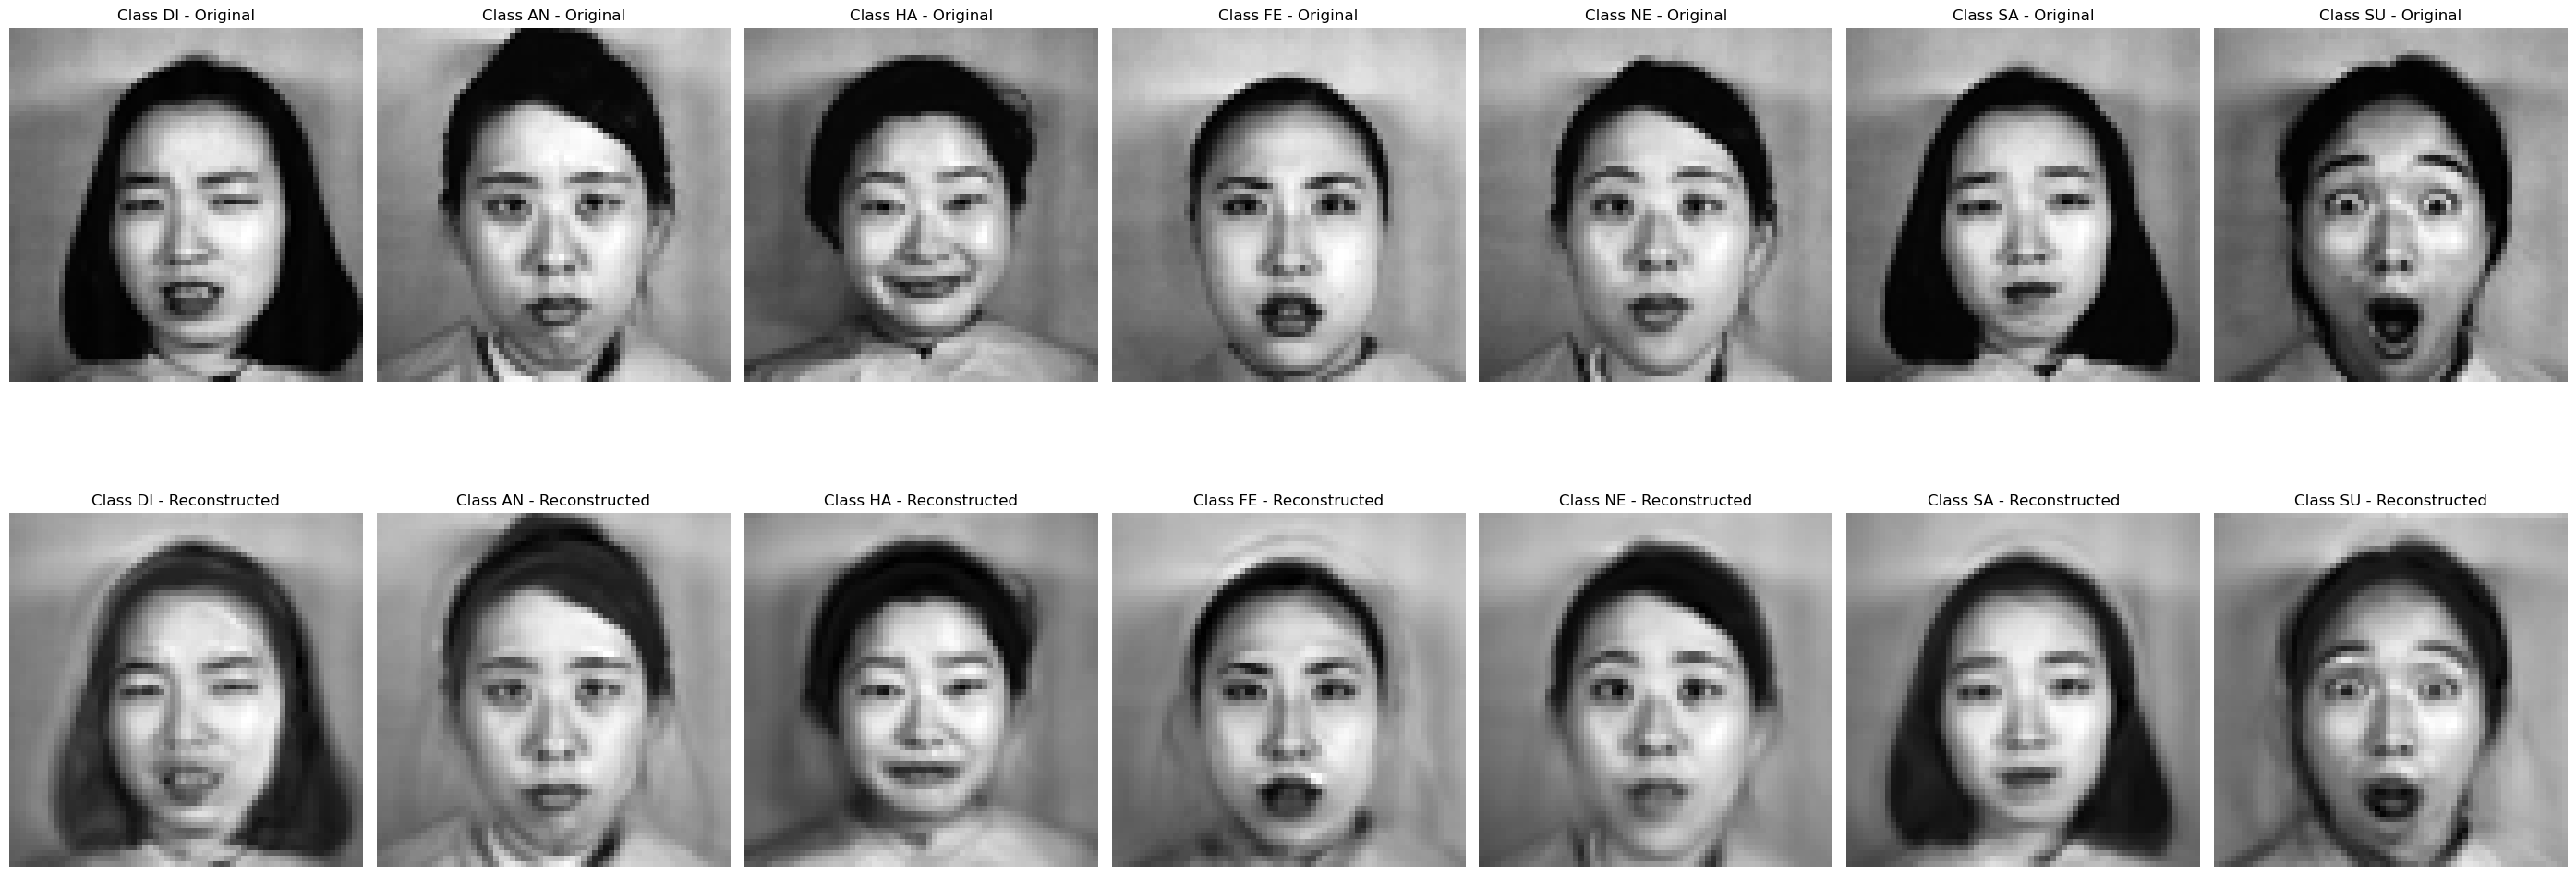

In [23]:
labels = dataset['Expression']
unique_classes = list(set(labels))

print("inverse transform images: ")
reconstructed_images_90_percent = pca_90_percent.inverse_transform(transformed_images_90_percent)
reconstructed_images_90_percent = reconstructed_images_90_percent.reshape(-1, *image_size)
fig, axes = plt.subplots(2, len(unique_classes), figsize=(4* len(unique_classes),12))

for i, class_label in enumerate(unique_classes):
    class_indices = np.where(labels == class_label)[0]
    random_index = np.random.choice(class_indices)
    original_image = images[random_index].reshape(image_size)
    reconstructed_image = reconstructed_images_90_percent[random_index]

    axes[0, i].imshow(original_image, cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Class {class_label} - Original')

    axes[1,i].imshow(reconstructed_image, cmap='gray')
    axes[1,i].axis('off')
    axes[1,i].set_title(f'Class {class_label} - Reconstructed')

plt.tight_layout()
plt.show()

In [24]:
transformed_images =  np.array([img.flatten() for img in transformed_images_90_percent])
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(transformed_images, labels, test_size=0.3, random_state=42)

In [34]:
qda = QuadraticDiscriminantAnalysis(reg_param=0.1)
qda.fit(X_train, y_train)

In [35]:
y_pred = qda.predict_likelihood(X_test)

In [36]:
accuracy_score(y_test, y_pred)

0.7450980392156863

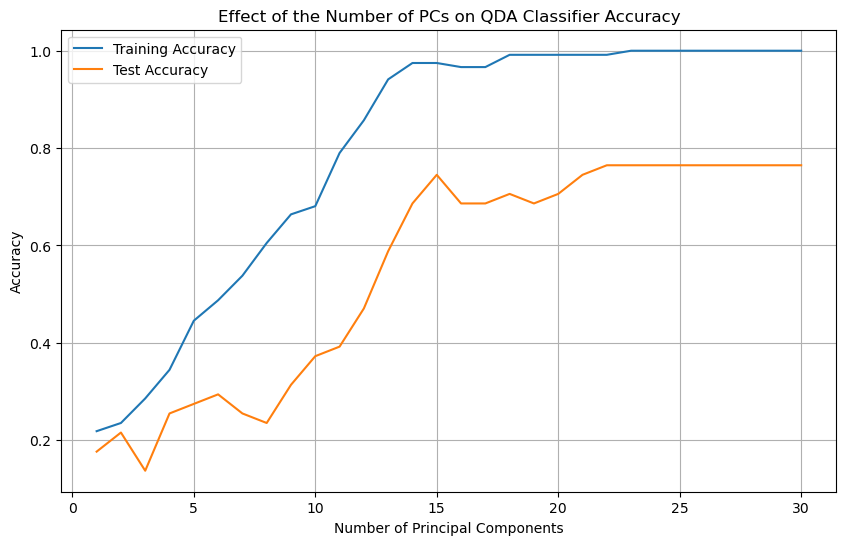

In [42]:
train_accuracies = []
test_accuracies = []
components_range = range(1, 31)

for n_components in components_range:
    pca = PCA(n_components=n_components)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    classifier = QuadraticDiscriminantAnalysis(0.1)
    classifier.fit(X_train_pca, y_train)

    # Training accuracy
    y_train_pred = classifier.predict_likelihood(X_train_pca)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)

    # Test accuracy
    y_test_pred = classifier.predict_likelihood(X_test_pca)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(components_range, train_accuracies, label='Training Accuracy')
plt.plot(components_range, test_accuracies, label='Test Accuracy')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.title('Effect of the Number of PCs on QDA Classifier Accuracy')
plt.legend()
plt.grid(True)
plt.show()
